In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import urllib.parse
import re
import requests as req
import datetime
import time
import seaborn as sns
import matplotlib as mpl
import os
from bs4 import BeautifulSoup as bs 
from PIL import Image as MImage
from IPython.display import Image
from matplotlib import rc
from matplotlib import font_manager
from tqdm import tqdm # for문 진행상황 눈으로 확인 (loading bar)
from datetime import date
from pytimekr import pytimekr
from wordcloud import WordCloud,ImageColorGenerator
from collections import Counter

from konlpy.tag import Kkma
kkma = Kkma() #Java download needed
from konlpy.tag import Okt


mpl.rc('axes', unicode_minus=False)


path = os.getcwd()

In [2]:
import os, sys

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
today = datetime.date.today() 
td = datetime.date.today().year
td=td-1

#1월 1일
ny=pytimekr.newyear(td)
# 추석
#pytimekr.chuseok(td)
# 설날
lny=pytimekr.lunar_newyear(td)
# 한글날
hg=pytimekr.hangul(td)
# 어린이날
chi=pytimekr.children(td)
# 광복절
ind=pytimekr.independence(td)
# 현충일
mem=pytimekr.memorial(td)
# 석가탄신일
bud=pytimekr.buddha(td)
# 삼일절
sam=pytimekr.samiljeol(td)
# 제헌절
con=pytimekr.constitution(td)

In [4]:
# 명사 추출
import nltk
# nltk.download('averaged_perceptron_tagger')

# 영어 불용어(stopwords) 사전
# nltk.download('stopwords')
from nltk.corpus import stopwords    
stopwords = set(stopwords.words('English')) 

# 단어/문장 단위로 토큰화
# nltk.download('punkt')
from nltk.tokenize import word_tokenize,sent_tokenize

In [7]:
urls = []

sdate = datetime.date(2022, 1, 1)         #언제부터
edate = datetime.date(2022, 1, 31)      #언제까지 #.today()

delta = edate - sdate  



 85%|██████████████████████████████████▉      | 99/116 [00:00<00:00, 108.58it/s]


 55%|██████████████████████▋                  | 66/119 [00:00<00:00, 108.34it/s]


100%|███████████████████████████████████████████| 26/26 [00:58<00:00,  2.25s/it]


<Figure size 1000x1000 with 0 Axes>

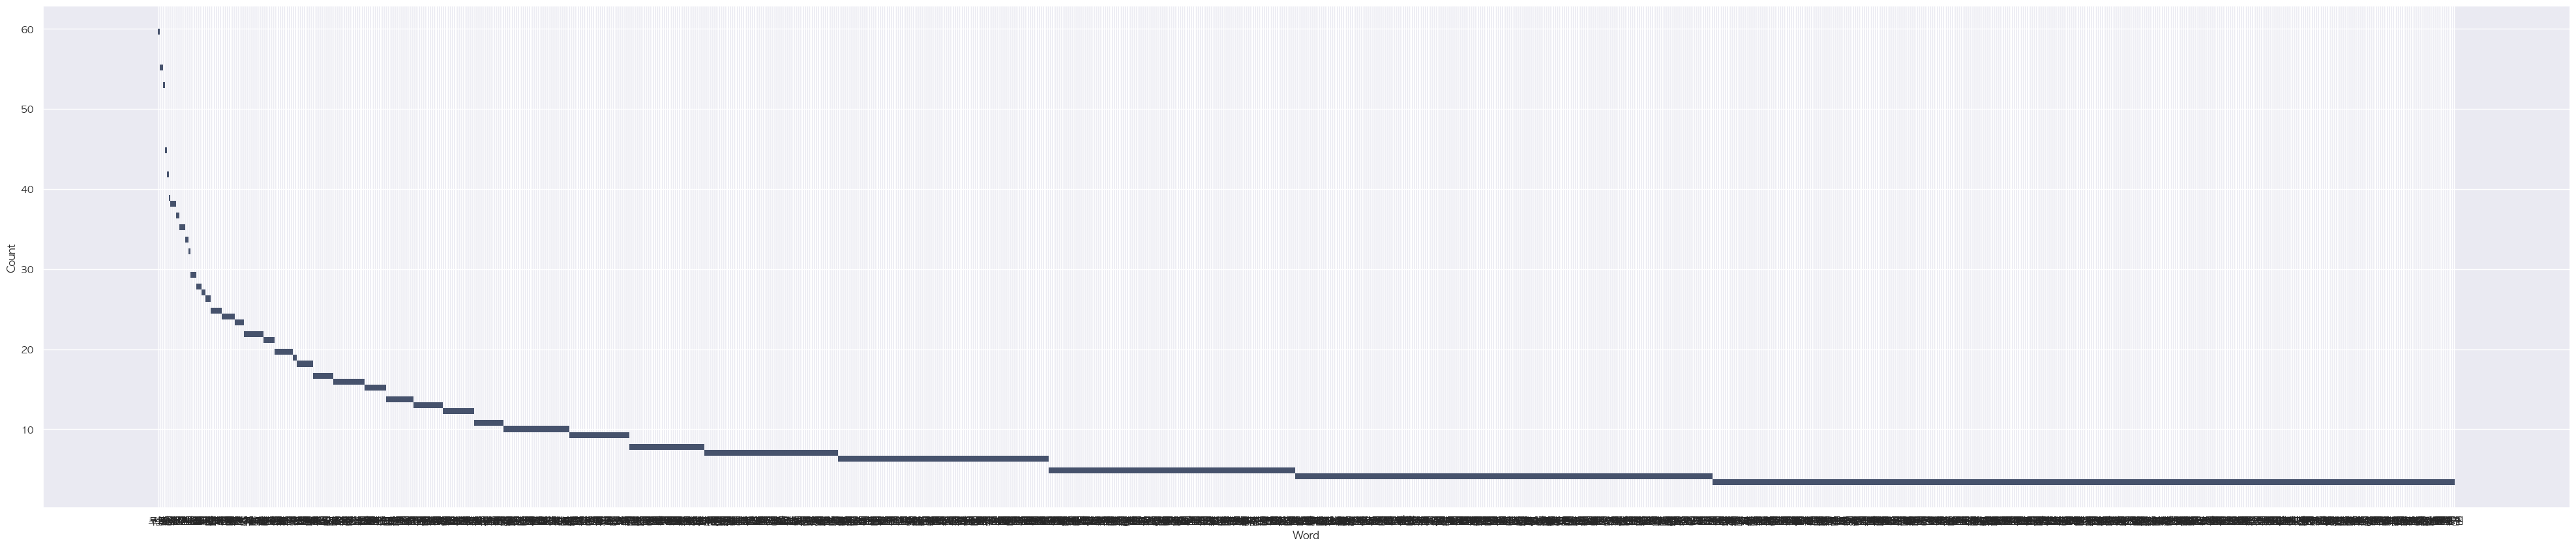

In [8]:
for i in range(delta.days + 1):
    day = sdate + datetime.timedelta(days=i)
    if day.weekday() == 6 :
        continue
    else:
        with HiddenPrints():
            print(day)
    wday = day.strftime("%Y/%m/%d")
    pday=wday.replace("/","-")
    urls.append('https://www.mk.co.kr/today-paper/01/'+str(wday))

with HiddenPrints():
    print(urls)
    
a=[]
for url in tqdm(urls):
    response=urllib.request.urlopen(url)
    soup=bs(response,'html.parser')
    html = soup.select('dd.news_tt.first > a') # 원하는 부분의 CSS 선택자 지정
    title = [x.text for x in html]


    for i in tqdm(range(len(title))):
        text = soup.select('dd.news_tt.first > a')[i].text
        a.append(text)
        
    time.sleep(1)

        
b=str(a)
b_filtered = b.replace('\n','').replace('\u200b','')
b_filtered = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\-\:\;\!\-\,\_\~\$\'\"]',' ',b_filtered.lower())
b_filtered = re.sub('\d',' ',b_filtered)
okt=Okt()  
c=okt.nouns(b_filtered)
d = [word for word in c if len(word)>1]
result = d
word_freq = Counter(d)
word_freq.most_common()
stopwords2 = ['지난해','매일경제','목소리','오늘','이제','년새','억원','억이','밸리','이름','달라','이후','이슈',
         '기업','사설','매경','단독','증시','뉴스','레이더','주요','기자','논의','포토','우리','이번','개월','한국','정부','신문','프리미엄','올해']
result = [w for w in result if w not in stopwords2]
word_freq = Counter(result)
word_freq.most_common()
AT=word_freq.most_common()
DF = pd.DataFrame(AT)
DF.to_csv(str(pday)+' ''MK.csv',header = ['Word','Count'])
df = pd.read_csv(str(pday)+' ''MK.csv')
dfd=df.drop(df[(df['Count'] <3)].index, inplace=True)

words = ' '.join(result)

wc = WordCloud(background_color="white")
wc = wc.generate(words)
wordcloud = WordCloud(
font_path = '/Library/Fonts/AppleGothic.ttf',    # 맥에선 한글폰트 설정 잘해야함.
background_color='white',                            # 배경 색깔 정하기
#mask=mask
colormap = 'Accent_r',                               # 폰트 색깔 정하기
width = 800,
height = 800
)

cloud = wordcloud.generate_from_frequencies(wc.words_)

array = wordcloud.to_array()
(type(array)) # numpy.ndarray
(array.shape) # (800, 800, 3)


wfig = plt.figure(figsize=(10,10))

#def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    #return("hsl(0,0%%, %d%%)" % np.random.randint(1,100))

cloud.to_file(str(pday)+' ''MKWordcloud.png')



sns.set(font="AppleGothic")
plt.figure(figsize=(50,10))
sfig=sns.histplot(data=df, x="Word",y="Count" )
sfig=sfig.get_figure()

sfig.savefig(str(pday)+' ''MKGraph.png')